In [1]:
import tensorflow
import cv2
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [37]:
training_path = os.path.join('dataset', 'test')
training_files_true = [os.path.join(training_path, 'true', x) for x in os.listdir(os.path.join(training_path, 'true'))]
training_files_false = [os.path.join(training_path, 'false', x) for x in
                        os.listdir(os.path.join(training_path, 'false'))]

dataset = training_files_true + training_files_false
# random.shuffle(dataset)

def extract_keys(e):
    splitted =  e.split('\\')[3].split('.')[0].split('_')
    return int(splitted[0]), int(splitted[1])
print(extract_keys(dataset[0]))
dataset = sorted(dataset, key=lambda key: extract_keys(key))
# print(dataset[600:700])

(0, 10000)


In [38]:
y = []
label = []
skip_value = 2_000_000
for img_path in tqdm(dataset):
    img = cv2.imread(img_path)
    etiquette = img_path.split('\\')[2] == 'true'
    numbers_bigger_than = (img[img > 220]).sum()
    if numbers_bigger_than > skip_value:
        numbers_bigger_than = skip_value
    y.append(numbers_bigger_than)
    label.append(etiquette)
x = list(range(len(y)))
print(len(x), len(y))

100%|██████████| 19630/19630 [01:20<00:00, 242.81it/s]

19630 19630


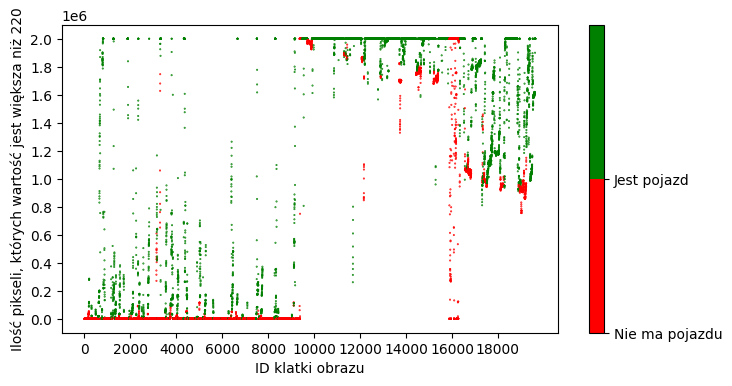

In [39]:
colors = ['red', 'green']
fig = plt.figure(figsize=(8, 4))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors), s=0.2)
cb = plt.colorbar()
loc = np.arange(0, max(label), max(label) / float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(['Nie ma pojazdu', 'Jest pojazd'])
plt.xlabel("ID klatki obrazu")
plt.ylabel("Ilość pikseli, których wartość jest większa niż 220")
plt.xticks(np.arange(min(x), max(x) + 1, 2000))

plt.yticks(np.arange(min(y), max(y) + 1, int((max(y) - min(y)) / 10)))
# plt.title('Analiza intensywości światła z czujnika')
plt.show()

In [19]:

TP = TN = FP = FN = 0
for img_path in tqdm(dataset):
    img = cv2.imread(img_path)
    etiquette = img_path.split('\\')[2] == 'true'
    numbers_bigger_than = (img[img > 220]).sum()
    prediction = numbers_bigger_than > 2000
    if prediction and etiquette:
        TP += 1
    elif prediction and not etiquette:
        FP += 1
    elif not prediction and etiquette:
        FN += 1
    else:
        TN += 1

100%|██████████| 19630/19630 [01:14<00:00, 265.14it/s]


In [20]:
print(TP, TN, FN, FP)

9585 7180 755 2110


In [21]:
accuracy = (TP + TN) / (TP + FN + TN + FP)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
print(accuracy, recall, precision)

0.8540499235863475 0.9269825918762089 0.8195810175288585


### Normalizacja

In [40]:
data = [[], [], [], []]
skip_value = 100_000
label = []
for img_path in tqdm(dataset):
    img = cv2.imread(img_path)
    etiquette = img_path.split('\\')[2] == 'true'
    video_id = int(img_path.split('\\')[3].split('_')[0])
    numbers_bigger_than = (img[img > 250]).sum()
    if numbers_bigger_than > skip_value:
        numbers_bigger_than = skip_value
    data[video_id].append([numbers_bigger_than, etiquette])

100%|██████████| 19630/19630 [01:22<00:00, 239.37it/s]


In [72]:
data_zcore = []
for batch in data:
    values = [x[0] for x in batch]
    std_y = np.std(values)
    mean = np.mean(values)
    for value, etiquette in batch:
        if value > skip_value:
            continue
        new_value = (value - mean) / std_y
        data_zcore.append([new_value, etiquette])
        
# y = [x[0] for x in data_zcore]
y = []
for x in data_zcore:
    if x[0] < -3:
        x[0] = -3
    y.append(x[0])

label = [x[1] for x in data_zcore]
x = list(range(len(y)))

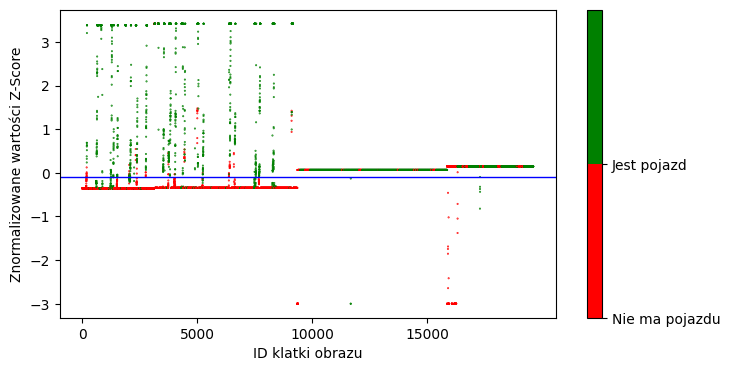

In [73]:
colors = ['red', 'green']
fig = plt.figure(figsize=(8, 4))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors), s=0.2)
plt.axhline(y = -0.1,linewidth=1, color = 'b', linestyle = '-')
cb = plt.colorbar()
loc = np.arange(0, max(label), max(label) / float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(['Nie ma pojazdu', 'Jest pojazd'])
plt.xlabel("ID klatki obrazu")
plt.ylabel("Znormalizowane wartości Z-Score")
plt.xticks(np.arange(min(x), max(x) + 1, 5000.0))
plt.yticks(np.arange(min(y), max(y), 1))
# plt.title('Analiza intensywości światła z czujnika')
plt.show()

In [67]:
TP = TN = FP = FN = 0
for numbers_bigger_than, etiquette in tqdm(data_zcore):
    # print(img_path)
    # img = cv2.imread(img_path)
    # etiquette = img_path.split('\\')[2] == 'true'
    # numbers_bigger_than = (img[img > 220]).sum()
    prediction = numbers_bigger_than > -0.05
    if prediction and etiquette:
        TP += 1
    elif prediction and not etiquette:
        FP += 1
    elif not prediction and etiquette:
        FN += 1
    else:
        TN += 1

100%|██████████| 19630/19630 [00:00<00:00, 3395504.27it/s]


In [66]:
print(TP, TN, FN, FP)

accuracy = (TP + TN) / (TP + FN + TN + FP)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
print(accuracy, recall, precision)

9443 7311 897 1979
0.8534895568008151 0.9132495164410058 0.8267378742777097
